# Load data

In [2]:
# importamos algunas librerías
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
#import plotly.express as px
#import imageio
import datetime 
import os
#import seaborn as sns
from Functions import SB_Albanese2020, bootstraping, add_accents
pd.set_option('display.max_colwidth', None)

In [3]:
#Import the main dataset
df = pd.read_csv('../MediaSharingIndex/Data/data.csv')
# Based on positive, negative and total mentions SB for each news article shared is calculated
df['SB'] = df.apply(lambda row: SB_Albanese2020(row), axis = 1)

In [4]:
# We filter taking urls with SB defined
df_sb = df.copy()
data_with_sentiment = df_sb.dropna(subset = ['dynamic_opinion','SB'])

In [5]:
data_with_sentiment[['outlet','dynamic_opinion','SB']]

,outlet,dynamic_opinion,SB
97,Clarin,MP,0.000000
99,Clarin,MP,0.000000
101,Clarin,MP,0.000000
109,El Destape,FF,-0.500000
184,El Destape,FF,0.000000
...,...,...,...
1038762,Infobae,FF,-0.285714
1038763,Infobae,MP,-0.285714
1038780,El Destape,FF,0.000000
1038783,El Destape,FF,0.000000


# Calculate SB 

In [6]:
SB_CL = data_with_sentiment[data_with_sentiment['dynamic_opinion']=='FF']['SB']
SB_CR = data_with_sentiment[data_with_sentiment['dynamic_opinion']=='MP']['SB']

print('Mean value SB CL: ', SB_CL.mean())
print('Mean value SB CR: ', SB_CR.mean())

Mean value SB CL:  -0.09784744540782125
Mean value SB CR:  0.03269105834549298


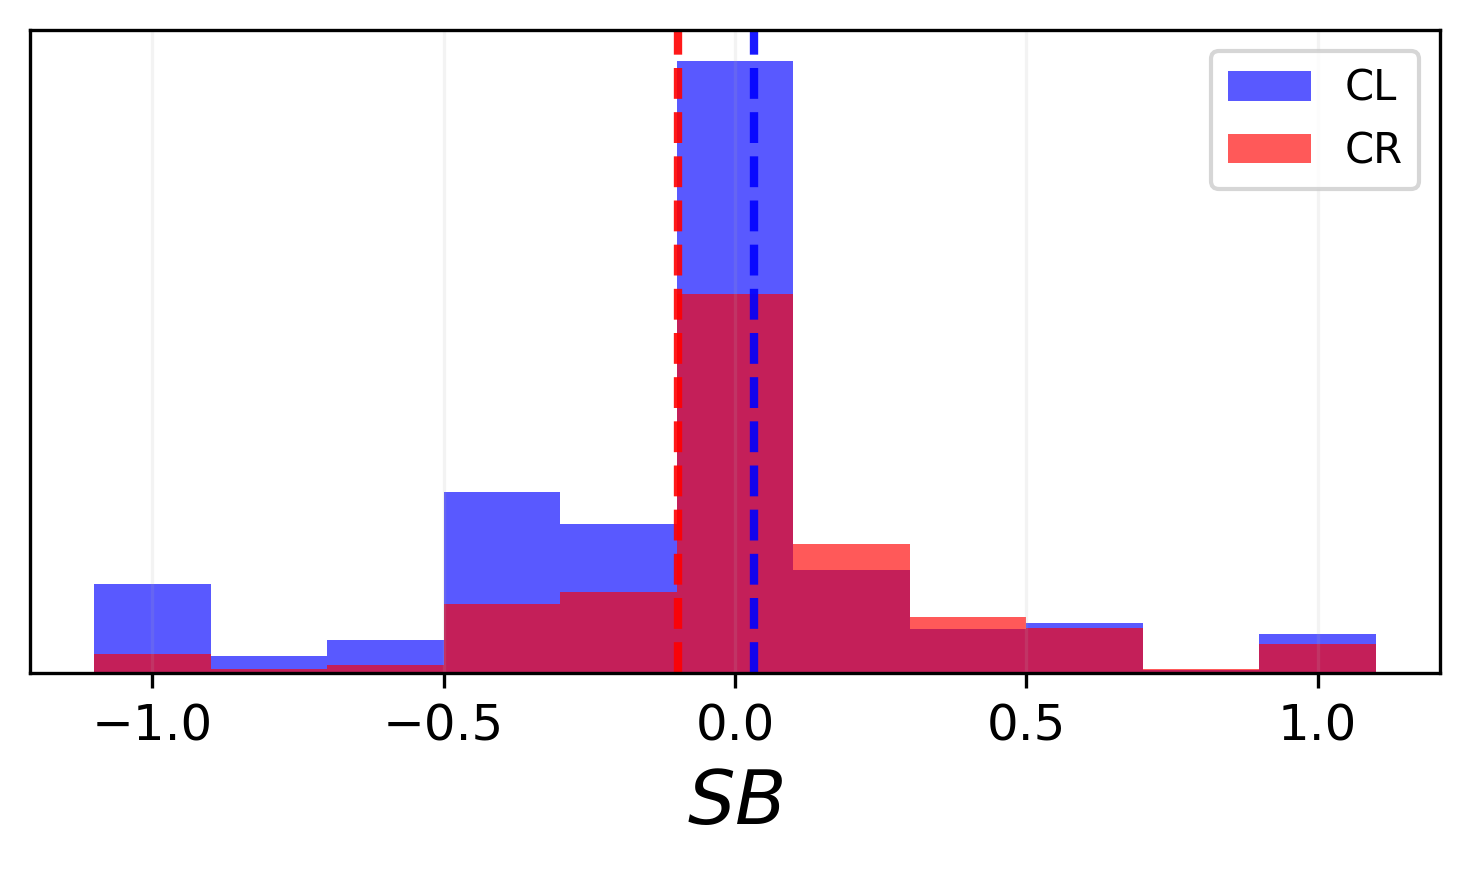

In [7]:
fig, ax = plt.subplots(figsize = (5, 3), dpi = 300)
SB_CL.hist(ax = ax, alpha = 0.65, color = 'b', bins = np.arange(-1.10, 1.11, 0.20), label = 'CL')
SB_CR.hist(ax = ax, alpha = 0.65, color = 'r', bins = np.arange(-1.10, 1.11, 0.20), label = 'CR')
ax.grid(alpha = 0.15)
plt.axvline(SB_CL.mean(), linewidth = 2, linestyle = '--', color = 'r', alpha = 0.90)
plt.axvline(SB_CR.mean(), linewidth = 2, linestyle = '--', color = 'b', alpha = 0.90)
plt.yticks([])
plt.xticks(size = 12)
plt.xlabel('$SB$', size = 18)
plt.legend(loc = 'best')
plt.tight_layout()
plt.savefig('New_figure3_0.pdf')
plt.show()

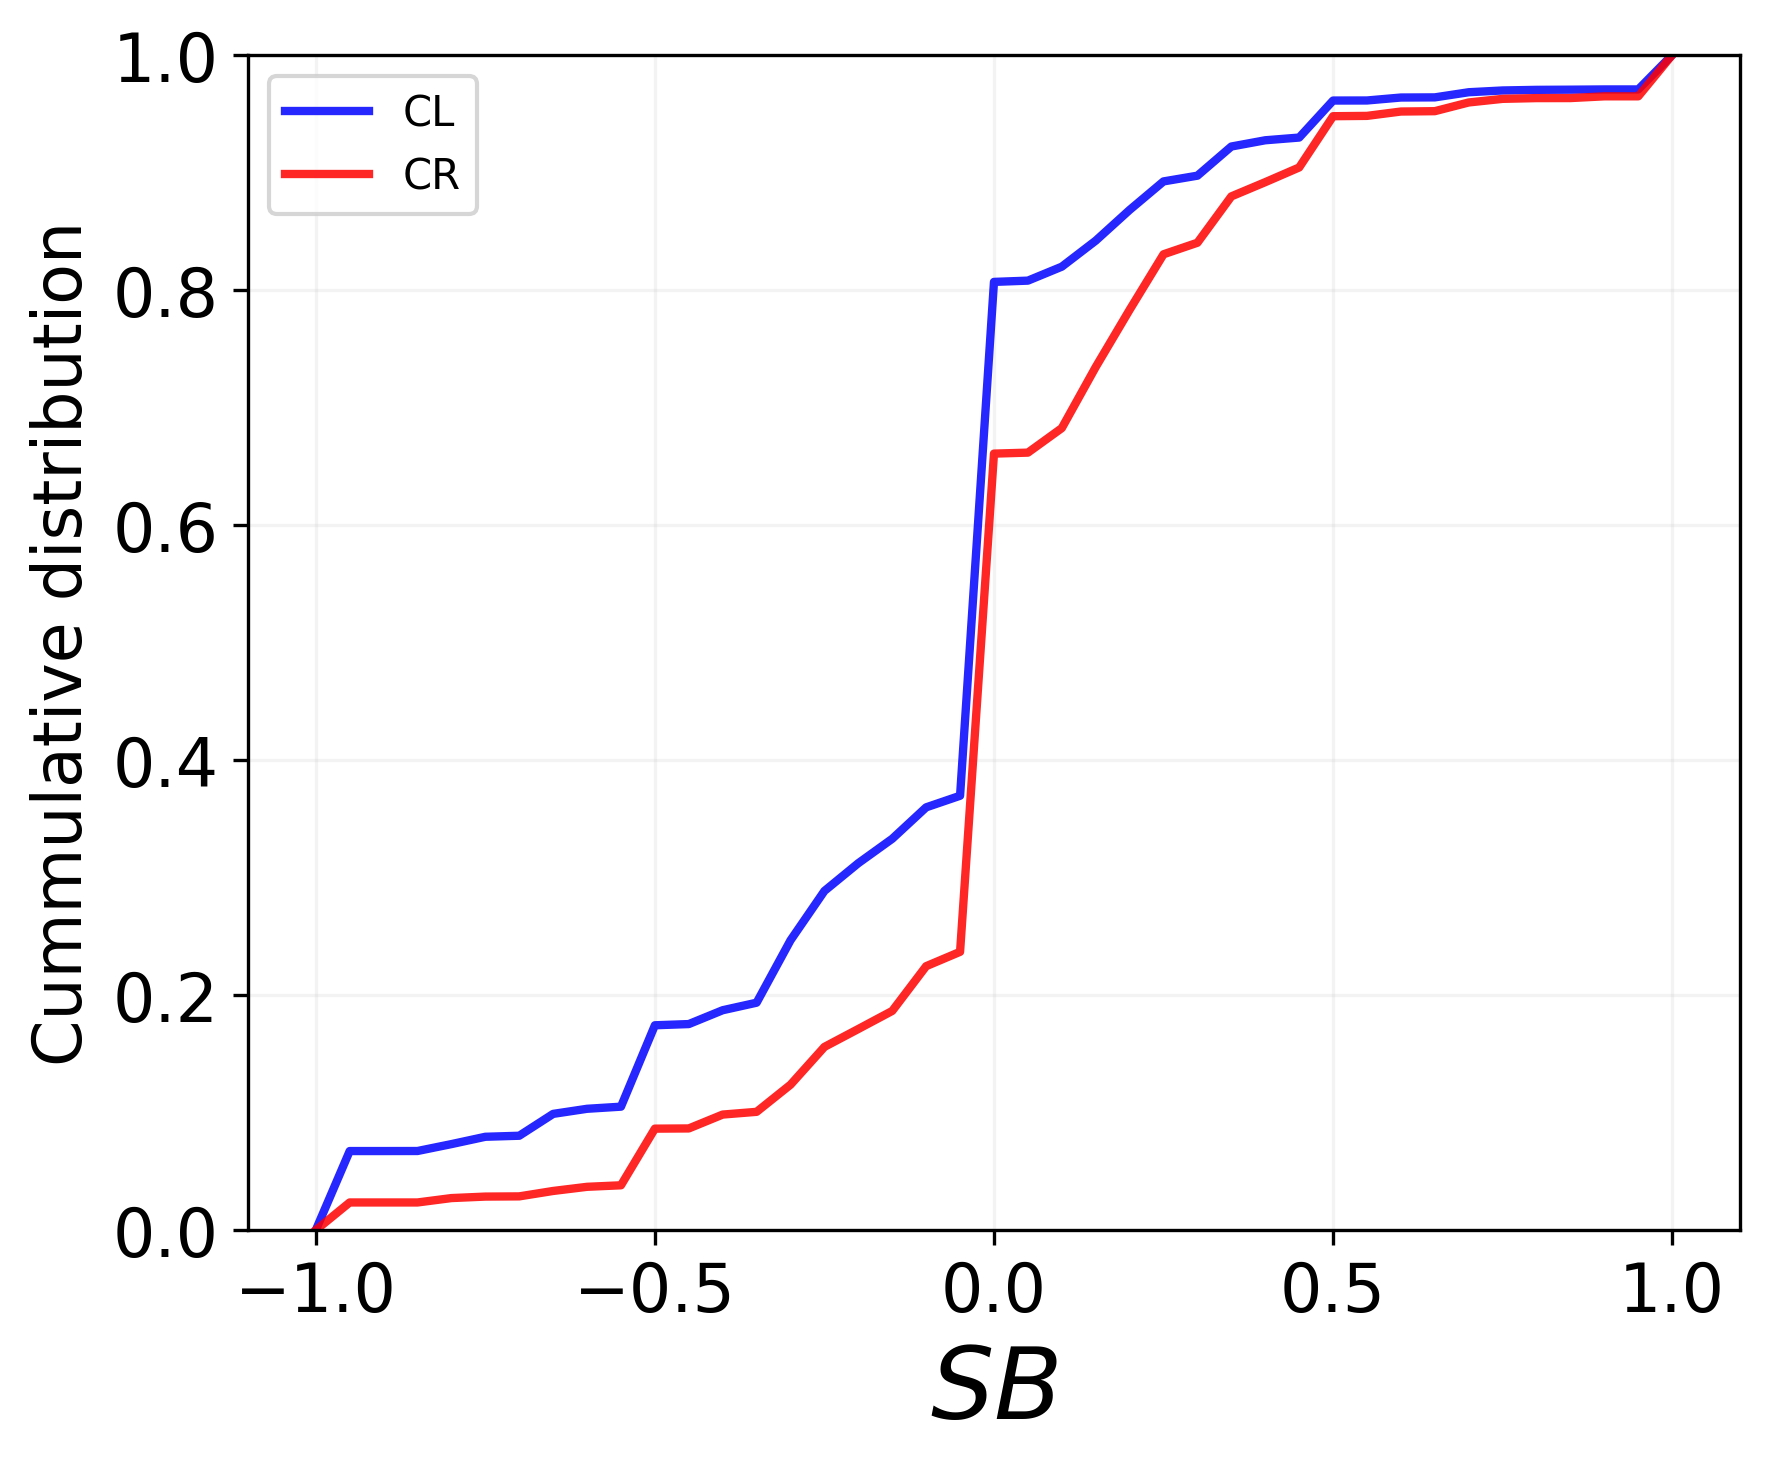

In [42]:
fig, ax = plt.subplots(figsize = (6, 5), dpi = 300)

xrange = np.arange(-1, 1.01, 0.05)
SB_CR_cum = [np.sum(SB_CR.to_numpy() < x) / SB_CR.shape[0] for x in xrange]
SB_CL_cum = [np.sum(SB_CL.to_numpy() < x) / SB_CL.shape[0] for x in xrange]

plt.plot(xrange, SB_CL_cum, color = 'b', linewidth = 2, alpha = 0.85, label = 'CL')
plt.plot(xrange, SB_CR_cum, color = 'r', linewidth = 2, alpha = 0.85, label = 'CR')
plt.grid(True, alpha = 0.15)
plt.ylim([0.00, 1.00])
plt.legend(loc = 'best')
plt.xlabel('$SB$', size = 24)
plt.xticks([-1, -0.5, 0., 0.5, 1], size = 16)
plt.yticks(size = 16)
plt.ylabel('Cummulative distribution', size = 16)
plt.tight_layout()
plt.savefig('Cummulative_distribution.png')
plt.show()

In [25]:
from scipy.stats import kstest 

kstest(SB_CL, SB_CR, alternative = 'greater')

KstestResult(statistic=0.1465956360864682, pvalue=0.0, statistic_location=0.06451612903225806, statistic_sign=1)

In [26]:
print('Mean value SB CL: ', SB_CL.mean())
print('Mean value SB CR: ', SB_CR.mean())

Mean value SB CL:  -0.09784744540782125
Mean value SB CR:  0.03269105834549298


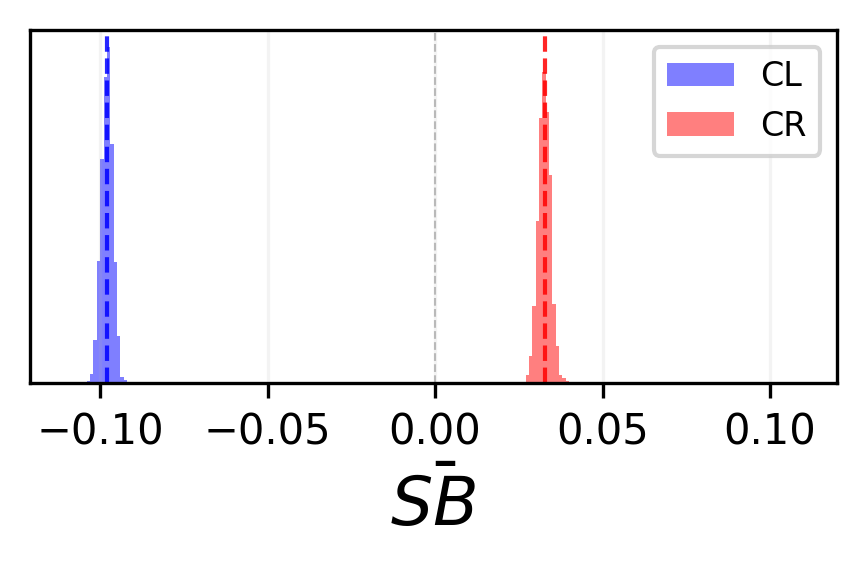

In [32]:
plt.figure(figsize = (3, 2), dpi = 300)

plt.hist([SB_CL.sample(n=SB_CL.shape[0], replace = True).mean() for i in range(1000)], bins = np.arange(-0.11, 0.11, 0.001), color = 'b', alpha = 0.50, label = 'CL')
plt.hist([SB_CR.sample(n=SB_CR.shape[0], replace = True).mean() for i in range(1000)], bins = np.arange(-0.11, 0.11, 0.001), color = 'r', alpha = 0.50, label = 'CR')

plt.axvline(SB_CL.mean(), color = 'b', linestyle = '--', alpha = 0.85, linewidth = 1)
plt.axvline(SB_CR.mean(), color = 'r', linestyle = '--', alpha = 0.85, linewidth = 1)
plt.axvline(0, color = 'grey', linestyle = '--', alpha = 0.50, linewidth = 0.5)
plt.xlabel(r'$\bar{SB}$', size = 16)
plt.xticks(size = 10)
plt.yticks([])
plt.legend(loc = 'best', fontsize = 8)
plt.grid(True, alpha = 0.15)
plt.tight_layout()
plt.savefig('New_figure3a.pdf')
plt.savefig('Mean_value.png')
plt.show()

# Calculate SB by outlet and partisans

In [8]:
# We calculated the mean SB by media outlet by partisan
mean_SB = data_with_sentiment[['outlet','dynamic_opinion','SB']].groupby(['dynamic_opinion','outlet']).mean().reset_index()
SB_CL = mean_SB[mean_SB['dynamic_opinion']=='FF']['SB'].to_list() # Center - Left mean Sentiment Bias
SB_CR = mean_SB[mean_SB['dynamic_opinion']=='MP']['SB'].to_list() # Center - Right mean Sentiment Bias

In [9]:
outlets = list(mean_SB[mean_SB['dynamic_opinion']=='MP'].outlet) # Filtering by 'FF' leads to the same outlets 

In [10]:
# Create two dictionary with media outlets as keys and their mean sentiment bias as values, one dictonary 
#calculated over news shared by CL users and another over CR users.
outlet_SB_CL = {o:s for o,s in zip(outlets,SB_CL)}
outlet_SB_CR = {o:s for o,s in zip(outlets,SB_CR)}
print('Mean Sentiment Bias by outlet calculated over news shared by CL users:')
outlet_SB_CL

Mean Sentiment Bias by outlet calculated over news shared by CL users:


{'Ambito Financiero': -0.14881125637952944,
 'Clarin': 0.02965964756626932,
 'Contexto': -0.23298771121351766,
 'El Cronista': -0.10343376871129178,
 'El Destape': -0.12934418670155273,
 'El Dia': -0.011539098301201376,
 'El Litoral': -0.23144490954408312,
 'Infobae': -0.026908728922454998,
 'Jornada': -0.12581699346405228,
 'La Izquierda Diario': -0.131572475697999,
 'La Nacion': 0.005665709906618047,
 'Minuto Uno': -0.2158055605792675,
 'Pagina 12': -0.18109065563550114,
 'Perfil': -0.06541362121167552,
 'Radio Dos': -0.026562500000000003,
 'Radio Mitre': 0.046508416450692425,
 'Todo Noticias': 0.02118823722185067}

In [11]:
print('Mean Sentiment Bias by outlet calculated over news shared by CR users:')
outlet_SB_CR

Mean Sentiment Bias by outlet calculated over news shared by CR users:


{'Ambito Financiero': -0.10587355485765379,
 'Clarin': 0.06474527200674354,
 'Contexto': -0.12115151515151515,
 'El Cronista': -0.0771649621348435,
 'El Destape': -0.18300419387375907,
 'El Dia': 0.010242872742872743,
 'El Litoral': -0.03252380952380952,
 'Infobae': 0.020506840968842026,
 'Jornada': -0.19047619047619047,
 'La Izquierda Diario': 0.015149858992689133,
 'La Nacion': 0.05745602521326775,
 'Minuto Uno': -0.2024046772809149,
 'Pagina 12': -0.11517766385023022,
 'Perfil': -0.060399951105171074,
 'Radio Dos': 0.17576628352490423,
 'Radio Mitre': 0.13374762465421047,
 'Todo Noticias': 0.05980517342759051}

# Filter less shared outlets

Filter outlets with at least N = 100 news per group of users (CL and CR partisans).

In [12]:
N = 100

In [13]:
#Number of tweets (frequently shared news) per  group
count_tweetsCL = data_with_sentiment[data_with_sentiment['dynamic_opinion']=='FF'].groupby('outlet').count().reset_index()[['outlet','url']]
count_tweetsCR =data_with_sentiment[data_with_sentiment['dynamic_opinion']=='MP'].groupby('outlet').count().reset_index()[['outlet','url']]

In [14]:
# Media outlets shared more than 100 times per group:
CL_outlets = count_tweetsCL[count_tweetsCL['url']>N].outlet
CR_outlets = count_tweetsCR[count_tweetsCR['url']>N].outlet

# Media outlets shared more than 100 times into the two groups:
outlets_filtered = list(set(CL_outlets).intersection(set(CR_outlets)))

In [15]:
# We calculate the mean SB error using bootstraping
df_CL = data_with_sentiment[data_with_sentiment['dynamic_opinion']=='FF']
df_CR = data_with_sentiment[data_with_sentiment['dynamic_opinion']=='MP']
CL_outlets_quantiles = {}
CR_outlets_quantiles = {}
outlet_SB_differences = {}

for o in outlets_filtered:
    CL_SBdistribution = df_CL[df_CL['outlet'] == o]['SB']
    CR_SBdistribution = df_CR[df_CR['outlet'] == o]['SB']
    sample_n = min(len(CL_SBdistribution),len(CR_SBdistribution))

    CL_boots = bootstraping(CL_SBdistribution,sample_n)
    CL_outlets_quantiles[o] = np.quantile(CL_boots, q = [0.005,0.995])
    
    CR_boots = bootstraping(CR_SBdistribution,sample_n)
    CR_outlets_quantiles[o] = np.quantile(CR_boots, q = [0.005,0.995])
    

    differences = [i-j for i,j in zip(CR_boots,CL_boots)]
    outlet_SB_differences[o] = differences

# Significance analysis

For each media outlet we calculate the statistical significance of the difference between mean Sentiment Bias for each user group (CL and CR partisans). Black stars in the follow plot depic the outlets that are significative.

In [16]:
is_significant = {}  # Dictionary to store significance values for each outlet

for o in outlets_filtered:
    dif = outlet_SB_differences[o]  # Differences for the current outlet
    mean = np.mean(dif)  # Calculate the mean of differences
    
    if mean > 0:
        if np.quantile(dif, q=0.01) > 0:
            S = 1  # Set S to 1 if the 0.01 quantile is greater than 0
        else:
            S = 0

    elif mean < 0:
        if np.quantile(dif, q=0.99) < 0:
            S = 1  # Set S to 1 if the 0.99 quantile is less than 0
        else:
            S = 0

    is_significant[o] = S  # Store the significance value for the current outlet in the dictionary
    del S  # Delete the temporary variable S

# Plot mean SB by outlet by partisan

Mean Sentiment Bias for news articles shared by CL and CR partisans within each media outlet.  Black stars denote cases where the difference of $\bar{SB}$ between CL and CR is statistically significant with $p < 0.01$.

In [17]:
# Order outlets by SB to plot
mean_SB_filtered = mean_SB[mean_SB['outlet'].isin(outlets_filtered)]
sorted_outlets = list(mean_SB_filtered[mean_SB_filtered['dynamic_opinion']=='FF'].sort_values(by = 'SB',ascending = False).outlet)

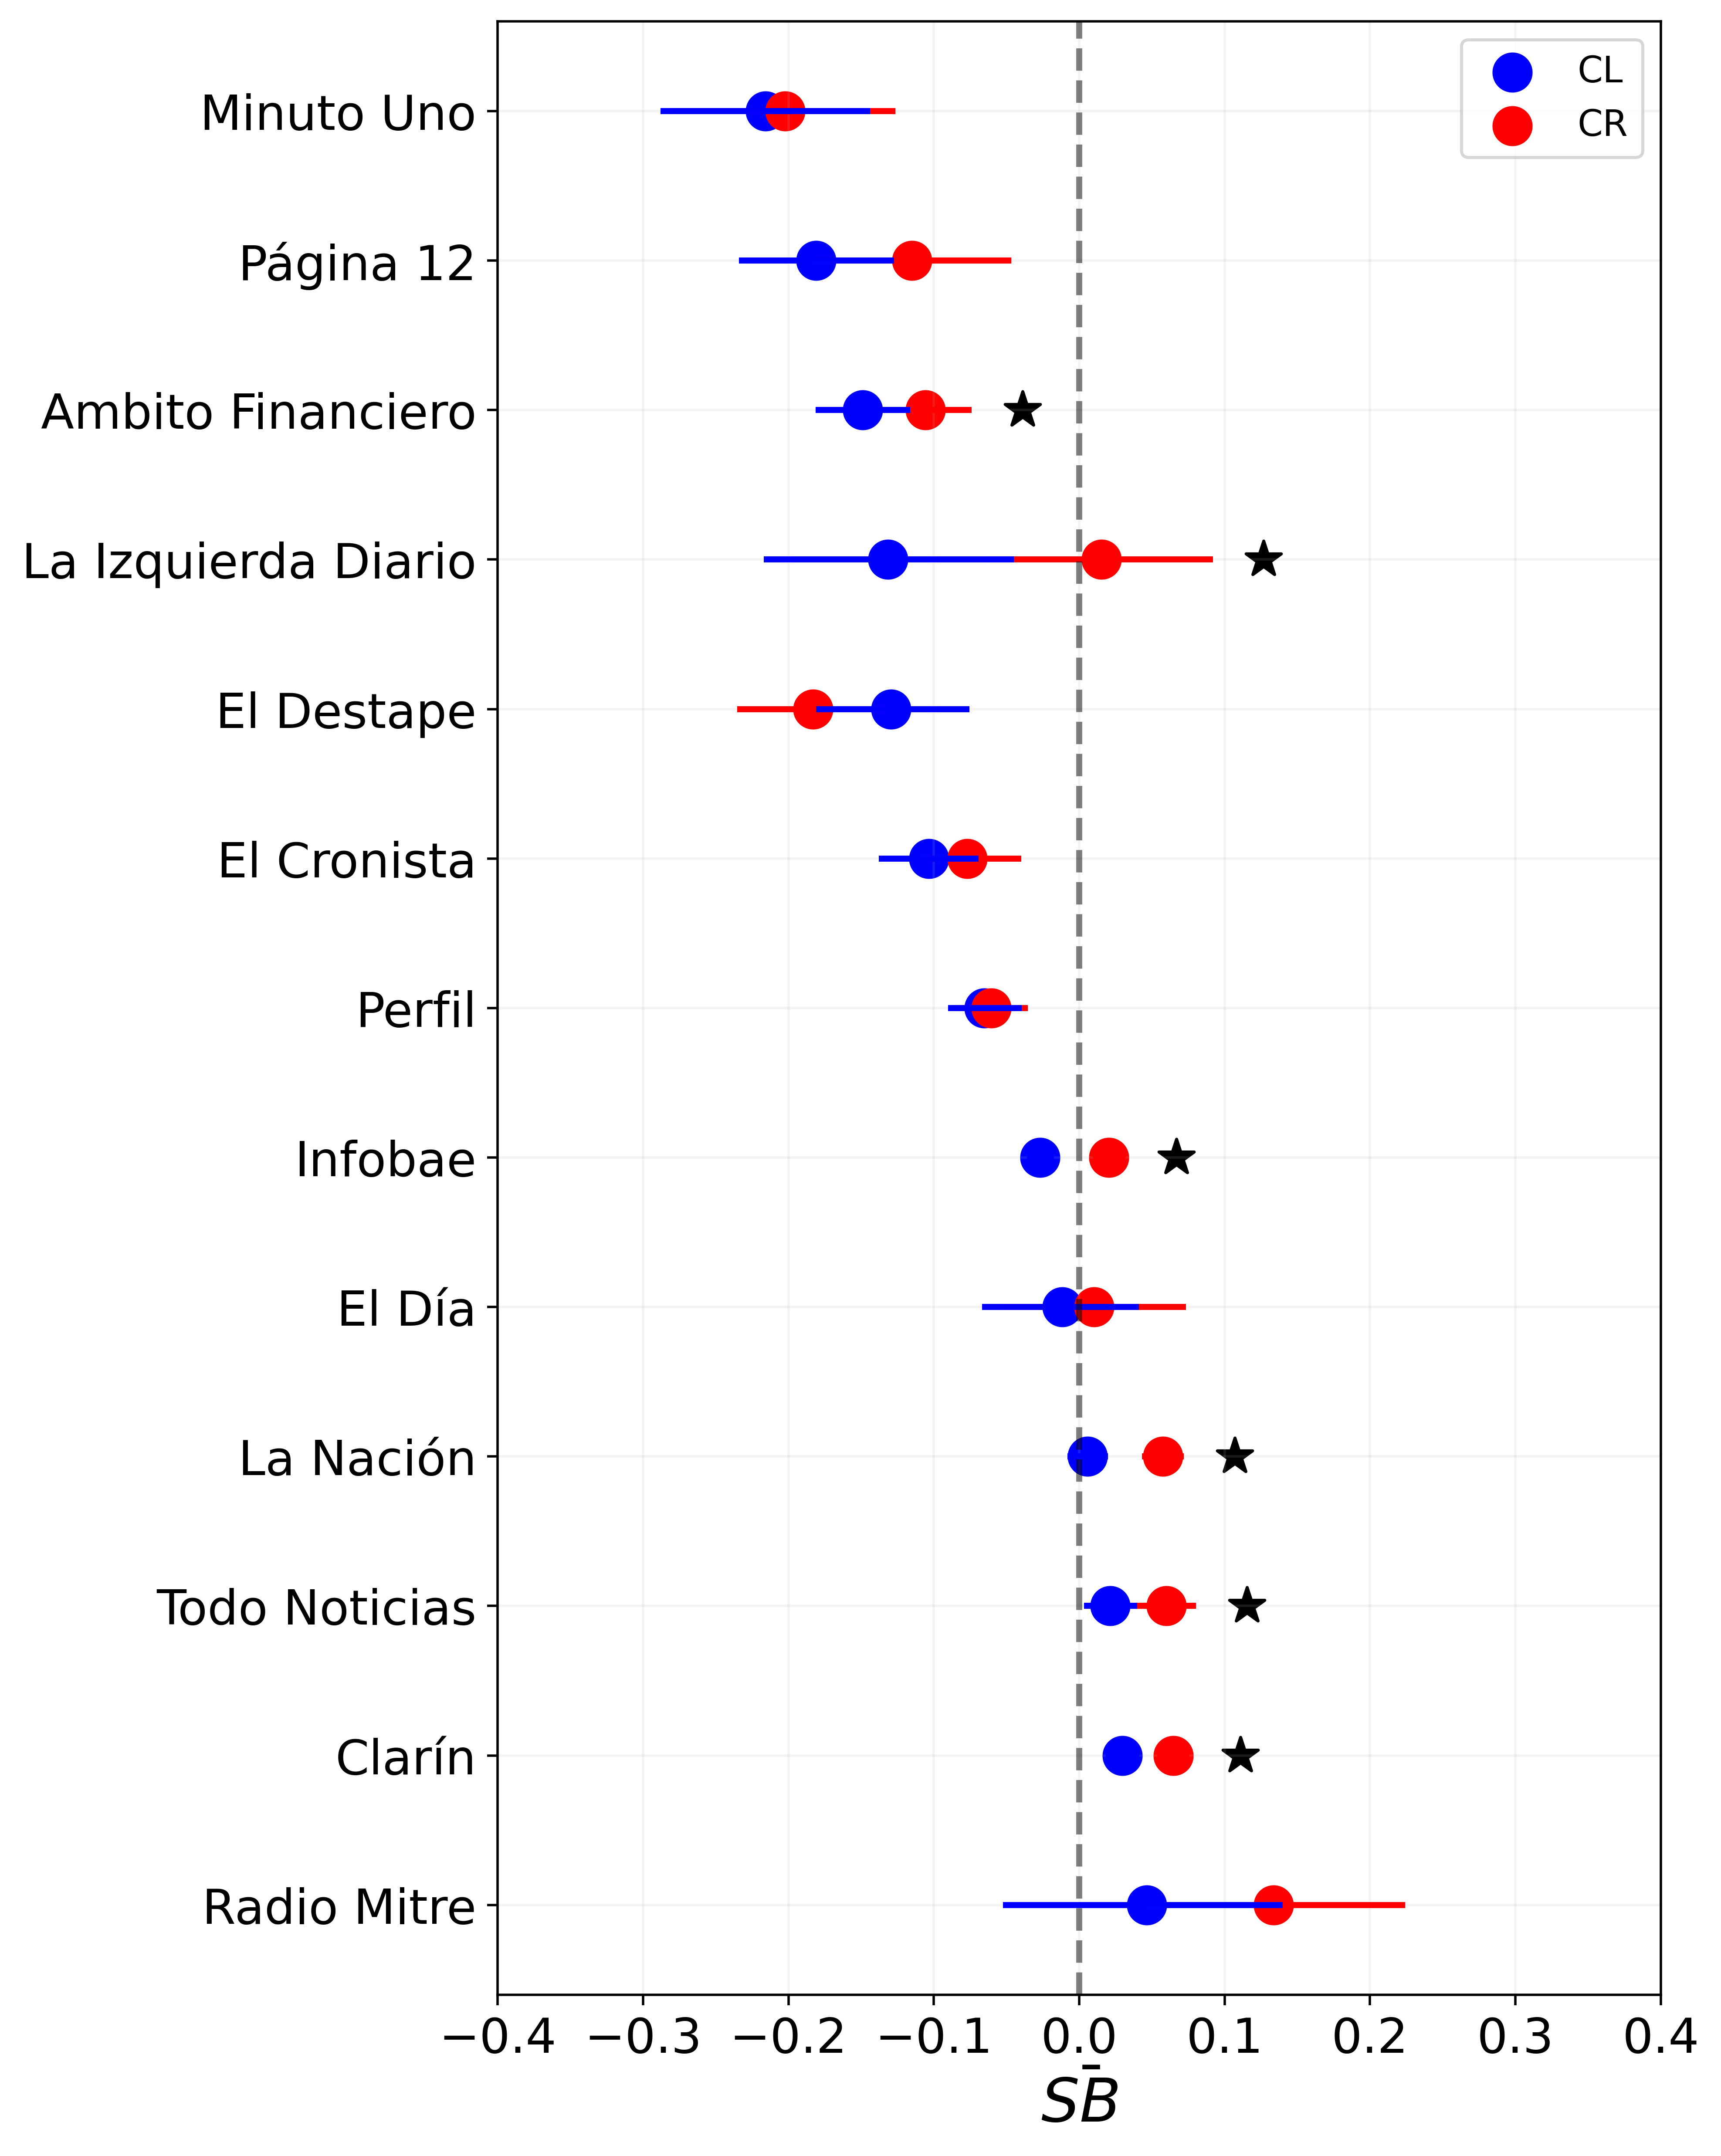

In [18]:
plt.figure(figsize= (8,10),dpi = 500)

for i,o in enumerate(sorted_outlets):
    plt.hlines(y= i , xmin=CR_outlets_quantiles[o][0], xmax=CR_outlets_quantiles[o][1], linewidth=2, color='r') 
    plt.hlines(y= i , xmin=CL_outlets_quantiles[o][0], xmax=CL_outlets_quantiles[o][1], linewidth=2, color='b')
    if i == 0:
        plt.scatter(outlet_SB_CL[o], i, label = 'CL',color = 'blue', s = 150)
        plt.scatter(outlet_SB_CR[o], i, label = 'CR',color = 'red', s = 150)
        
    else:
        plt.scatter(outlet_SB_CL[o], i, color = 'blue', s = 150) 
        plt.scatter(outlet_SB_CR[o], i,color = 'red', s = 150)
        
        
    if is_significant[o]==1:
        x = max(CR_outlets_quantiles[o][1],CL_outlets_quantiles[o][1])+ 0.035
        plt.scatter(x,i,marker = '*',color = 'black',s = 150)

        plt.xticks(np.arange(-0.4, 0.41, 0.1), size = 16)


        plt.xticks(np.arange(-0.4, 0.41, 0.1), size = 16)
plt.xlim([-0.4,0.4])
plt.axvline(0.00, color = 'k', linewidth = 2, linestyle = '--',  alpha = 0.50)
sorted_outlets_accents = [add_accents(m) for m in sorted_outlets]
plt.yticks(range(len(sorted_outlets_accents)), sorted_outlets_accents, size = 16)
plt.xlabel(r'$\bar{SB}$', size = 20)
plt.legend(fontsize = 12)
plt.grid(True, alpha = 0.15)
plt.tight_layout()
plt.savefig('New_figure3b.pdf')
plt.show()